In [25]:
%matplotlib widget

import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the two pickle files containing delta_kappas
# pickle_file1 = 'delta_kappas_original_20250314104930.pkl'  # From Desktop
pickle_file1 = 'delta_kappas_original_20250314133342.pkl'  # From Laptop
# pickle_file1 = 'delta_kappas_rob-updates_20250314104917.pkl'
# pickle_file2 = 'delta_kappas_rob-updates_20250314103536_original_loop_order.pkl'
pickle_file2 = 'delta_kappas_rob-updates_20250314100927_no_seed.pkl'  # From Desktop

with open(pickle_file1, 'rb') as f1:
    delta_kappas1 = pickle.load(f1)

with open(pickle_file2, 'rb') as f2:
    delta_kappas2 = pickle.load(f2)

In [26]:
# Compare the numeric output for consistency between the two files

# Define top N and descriptive cutoff variable (set as a decimal fraction; 0.05 equals 5%)
top_n = 5
diff_ci_ratio_threshold = 0.05  # 5%

comparison_results = []  # List to store details for summary

categories = set(delta_kappas1.keys()) | set(delta_kappas2.keys())
for category in categories:
    print(f"Category: {category}")
    models1 = delta_kappas1.get(category, {})
    models2 = delta_kappas2.get(category, {})
    model_names = set(models1.keys()) | set(models2.keys())
    for model in model_names:
        groups1 = models1.get(model, {})
        groups2 = models2.get(model, {})
        common_groups = set(groups1.keys()) & set(groups2.keys())
        for group in common_groups:
            value1, ci1 = groups1[group]
            value2, ci2 = groups2[group]
            diff = value1 - value2
            # Calculate the half-width (margin) of the 95\% CI for each file
            margin1 = (ci1[1] - ci1[0]) / 2
            margin2 = (ci2[1] - ci2[0]) / 2
            combined_margin = margin1 + margin2

            # Calculate ratio of diff to combined margin.
            ratio = diff / combined_margin if combined_margin != 0 else np.nan

            # Flag if the absolute ratio exceeds the diff_ci_ratio_threshold
            flag = ""
            if not np.isnan(ratio) and abs(ratio) > diff_ci_ratio_threshold:
                flag = "FLAG: Diff/Combined > {}%".format(diff_ci_ratio_threshold * 100)

            print(f"  Model: {model}, Group: {group}")
            print(f"    File1: {value1:.4f} (95\\% CI: {ci1[0]:.4f} to {ci1[1]:.4f})")
            print(f"    File2: {value2:.4f} (95\\% CI: {ci2[0]:.4f} to {ci2[1]:.4f})")
            print(f"    Diff: {diff:.4f} | Combined Margin: {combined_margin:.4f} | Diff/Combined = {ratio:.4f} {flag}")

            # Store results for summary if ratio is a valid number
            if not np.isnan(ratio):
                comparison_results.append({
                    'category': category,
                    'model': model,
                    'group': group,
                    'value1': value1,
                    'value2': value2,
                    'diff': diff,
                    'combined_margin': combined_margin,
                    'ratio': ratio,
                    'flag': flag
                })

# After printing all details, create a summary of the top N ratios with largest distance from zero.
sorted_results = sorted(comparison_results, key=lambda x: abs(x['ratio']), reverse=True)
print("\nSummary of top", top_n, "ratio values farthest from zero:")
print("---------------------------------------------")
for idx, result in enumerate(sorted_results[:top_n], start=1):
    flag_msg = f" | {result['flag']}" if result['flag'] else ""
    print(f"{idx}) Category: {result['category']} | Model: {result['model']} | Group: {result['group']}")
    print(f"    File1: {result['value1']:.4f} | File2: {result['value2']:.4f}")
    print(f"    Diff: {result['diff']:.4f} | Combined Margin: {result['combined_margin']:.4f} | Ratio: {result['ratio']:.4f}{flag_msg}")

Category: ethnicity
  Model: ai_model_7, Group: Hispanic or Latino
    File1: 0.0453 (95\% CI: -0.0308 to 0.1198)
    File2: 0.0480 (95\% CI: -0.0282 to 0.1242)
    Diff: -0.0027 | Combined Margin: 0.1515 | Diff/Combined = -0.0176 
  Model: ai_model_6, Group: Hispanic or Latino
    File1: -0.0459 (95\% CI: -0.1093 to 0.0261)
    File2: -0.0386 (95\% CI: -0.1036 to 0.0288)
    Diff: -0.0072 | Combined Margin: 0.1339 | Diff/Combined = -0.0540 FLAG: Diff/Combined > 5.0%
  Model: ai_model_2, Group: Hispanic or Latino
    File1: -0.0161 (95\% CI: -0.0923 to 0.0583)
    File2: -0.0075 (95\% CI: -0.0826 to 0.0705)
    Diff: -0.0086 | Combined Margin: 0.1518 | Diff/Combined = -0.0569 FLAG: Diff/Combined > 5.0%
  Model: ai_model_3, Group: Hispanic or Latino
    File1: -0.0024 (95\% CI: -0.0597 to 0.0593)
    File2: -0.0011 (95\% CI: -0.0634 to 0.0589)
    Diff: -0.0013 | Combined Margin: 0.1206 | Diff/Combined = -0.0111 
  Model: ai_model_1, Group: Hispanic or Latino
    File1: -0.0014 (95\% CI

In [3]:
delta_kappas1['age_binned']['ai_model_1']['65-74']

(np.float64(-0.06376001345733218),
 (np.float64(-0.1540465457449594), np.float64(0.03826333195443783)))

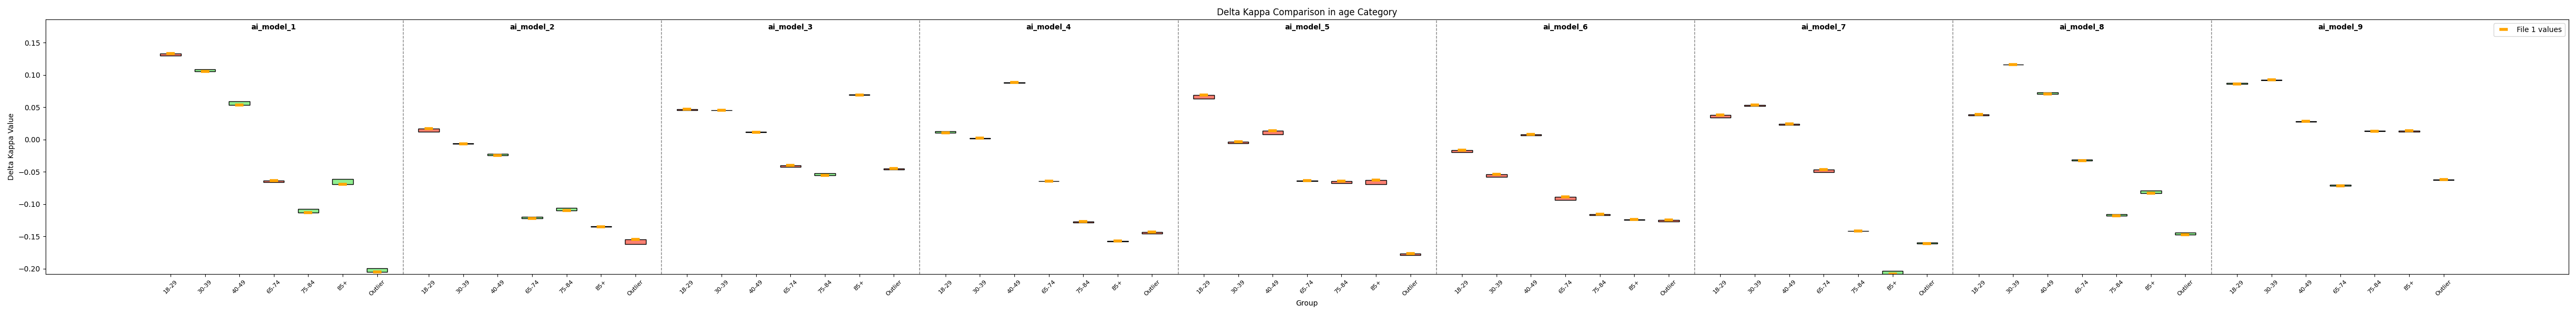

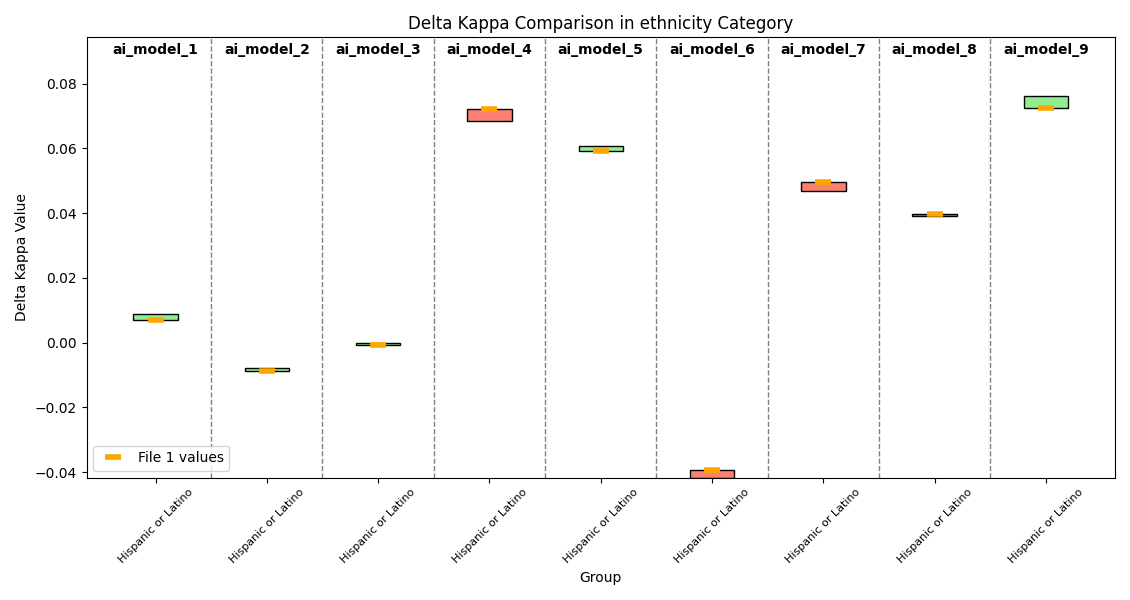

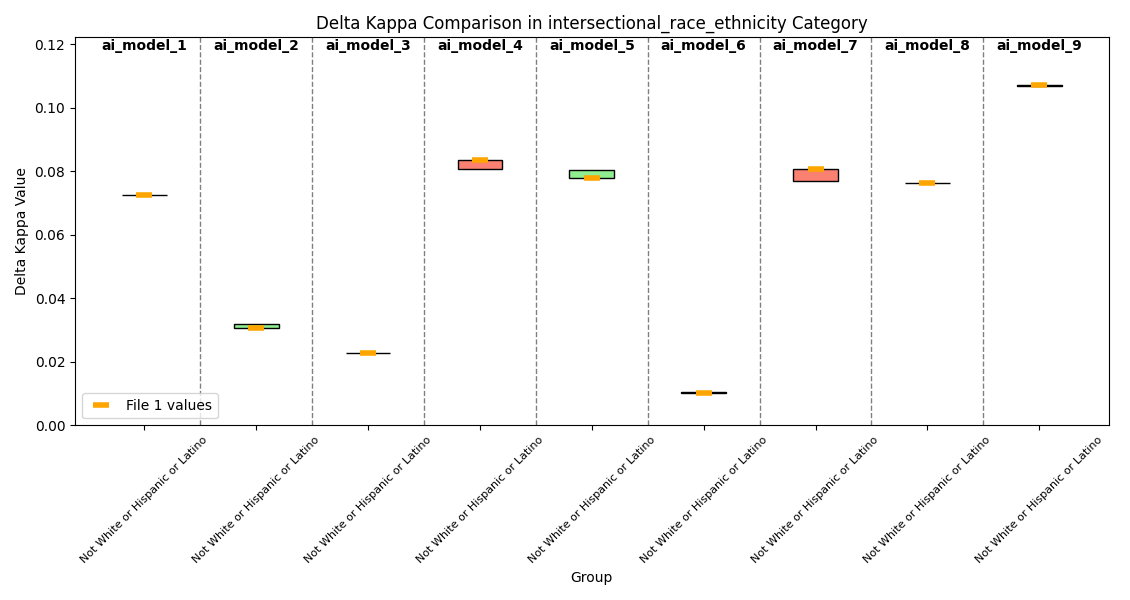

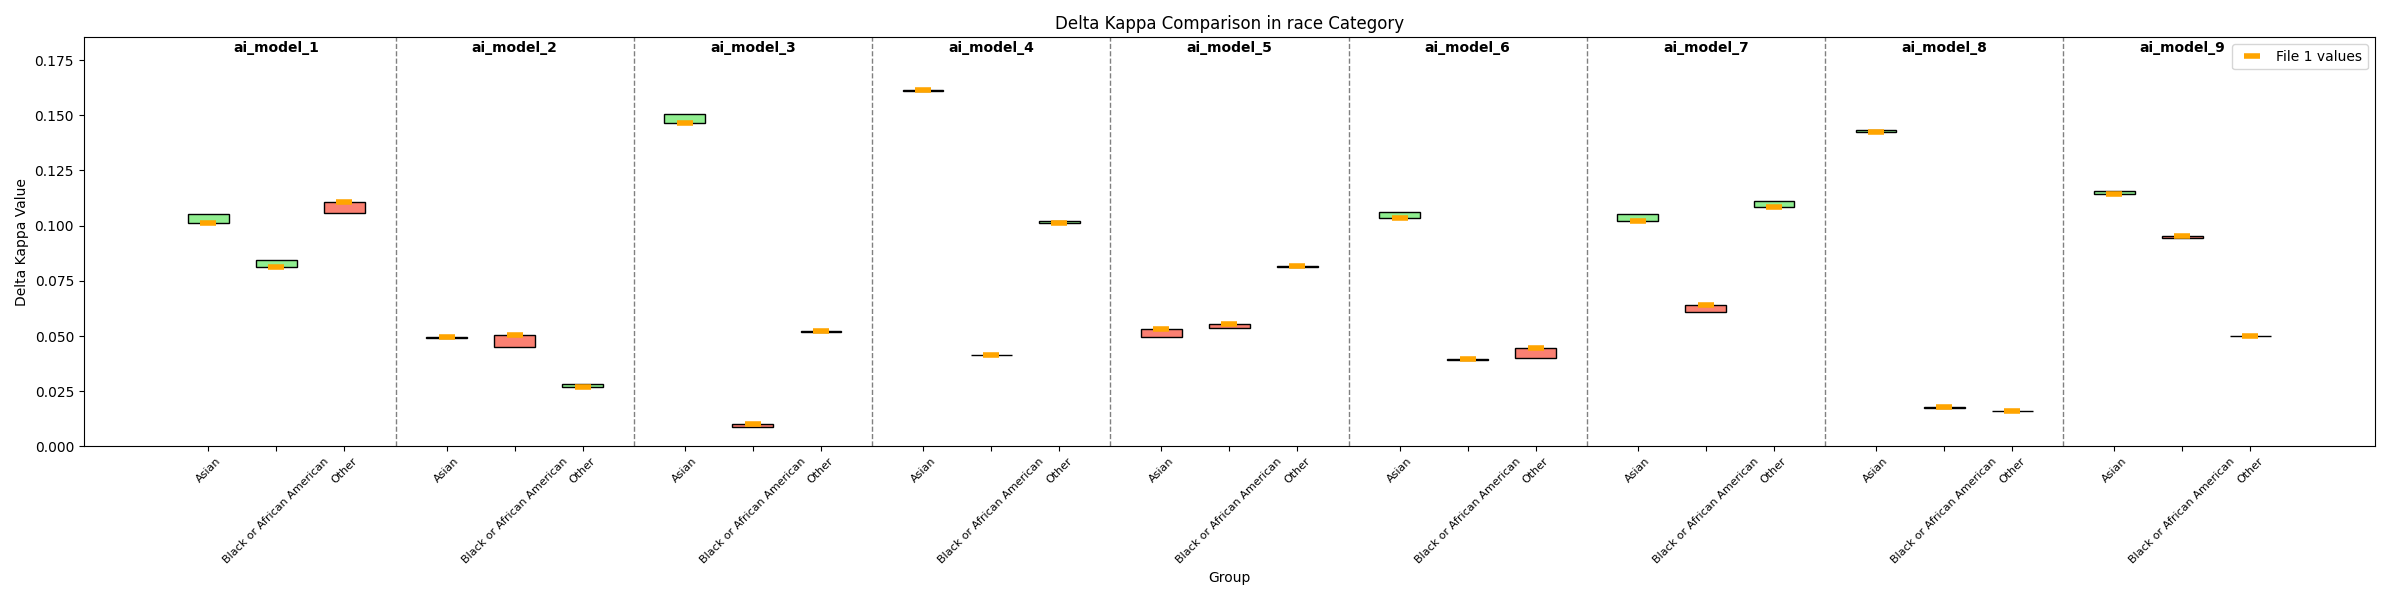

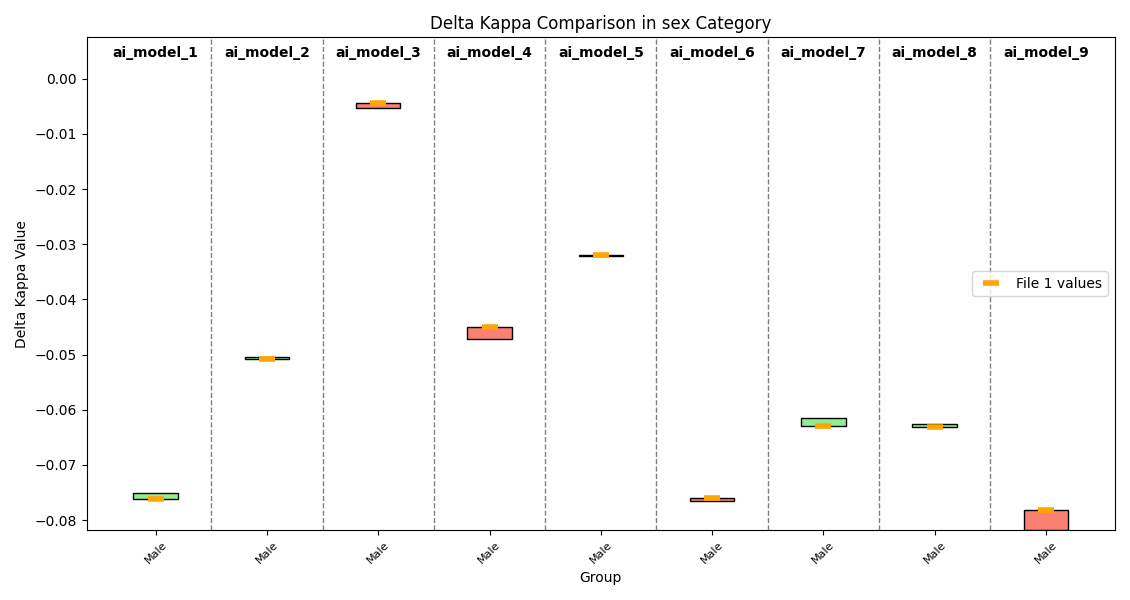

In [2]:
# Define the number of models to plot and create a list of model names
N = 9  # Change N as required
models_to_plot = [f"ai_model_{i}" for i in range(1, N+1)]

# Get common categories between the two files
common_categories = sorted(set(delta_kappas1.keys()) & set(delta_kappas2.keys()))

# Loop over each common category
for category in common_categories:
    x_positions = []       # Positions for each group bar
    bar_bottoms = []       # Bottom y-values for bars
    bar_heights = []       # Heights (absolute differences)
    bar_colors = []        # Bar colors
    file1_values = []      # File1 values for marker plotting
    xtick_labels = []      # Only the group label appears here
    model_centers = []     # (center_x, model_name) for annotating model name on top
    model_separator_positions = []  # Positions for the vertical dashed separators

    current_x = 0
    # Loop over each model
    for model in models_to_plot:
        model_start = current_x  # Start position of a model
        count = 0
        if (model in delta_kappas1[category] and model in delta_kappas2[category]):
            groups1 = set(delta_kappas1[category][model].keys())
            groups2 = set(delta_kappas2[category][model].keys())
            common_groups = sorted(groups1 & groups2)
            for group in common_groups:
                val1, _ = delta_kappas1[category][model][group]
                val2, _ = delta_kappas2[category][model][group]
                if val2 >= val1:
                    bottom = val1
                    height = val2 - val1
                    color = 'lightgreen'
                else:
                    bottom = val2
                    height = val1 - val2
                    color = 'salmon'
                x_positions.append(current_x)
                bar_bottoms.append(bottom)
                bar_heights.append(height)
                bar_colors.append(color)
                file1_values.append(val1)
                xtick_labels.append(group)  # Only group label is used here
                current_x += 1
                count += 1
        # If any groups were processed for the model, record the model center and separator
        if count > 0:
            model_end = current_x  # End position after last group
            center = (model_start + model_end) / 2
            model_centers.append((center - 0.50, model))
            # Compute the separator as the middle of the gap (extra gap is 0.5, so middle is model_end - 0.25)
            model_separator_positions.append(model_end - 0.25)
        # Add an extra gap to separate models visually
        current_x += 0.5

    # Only plot if there is any data
    if x_positions:
        if category == 'age_binned':
            category = 'age'
        plt.figure(figsize=(5 + len(x_positions) * 0.7, 6))
        plt.bar(x_positions, bar_heights, width=0.6, bottom=bar_bottoms, color=bar_colors, edgecolor='black')
        plt.plot(
            x_positions,
            file1_values,
            linestyle='None',
            marker='_',
            markersize=12,
            markeredgewidth=4,
            color='orange',
            label='File 1 values'
        )
        plt.xlabel('Group')
        plt.ylabel('Delta Kappa Value')
        plt.title(f'Delta Kappa Comparison in {category} Category')
        plt.xticks(x_positions, xtick_labels, rotation=45, fontsize=8)
        plt.legend()

        # Annotate model names near the top of the plot
        y_min, y_max = plt.ylim()
        y_offset = (y_max - y_min) * 0.05
        for center, model in model_centers:
            plt.text(center, y_max + y_offset, model, ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.ylim(min(y_min, 0), y_max + y_offset * 2)

        # Draw vertical dashed lines between models (omit the last separator)
        for sep in model_separator_positions[:-1]:
            plt.axvline(x=sep, color='gray', linestyle='--', linewidth=1)

        # For wide plots, freeze the y-axis to allow only horizontal zooming and panning.
        if len(x_positions) > 20:
            ax = plt.gca()
            fixed_ylim = plt.ylim()  # Store current y-axis limits
            ax.set_autoscale_on(False)  # Disable autoscaling so y remains unchanged
            ax.set_ylim(fixed_ylim)
            # Activate the pan tool by default (if supported by the backend)
            fig = plt.gcf()
            if hasattr(fig.canvas, 'toolbar') and hasattr(fig.canvas.toolbar, 'pan'):
                fig.canvas.toolbar.pan()

        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available in category {category} for the specified models.")